# 03 - Risk Scoring Framework

This notebook demonstrates the multi-dimensional risk scoring methodology.

**Risk Components:**
1. **Frequency** (35%): Historical event count
2. **Trend** (25%): Are events increasing over time?
3. **MTBF** (20%): Mean time between failures (inverted)
4. **Age** (10%): Equipment age
5. **Recency** (10%): Time since last event (inverted)

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import load_pmu_disturbance_data
from risk_scorer import PMURiskScorer

DATA_PATH = '../../data/PMU_disturbance.xlsx'
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load Data

In [2]:
pmu_df, dist_df = load_pmu_disturbance_data(DATA_PATH)
print(f"Loaded {len(pmu_df)} PMUs and {len(dist_df)} events")

Loaded 533 PMUs and 9369 events


## 2. Calculate Risk Scores

In [3]:
# Default weights
default_weights = {
    'frequency': 0.35,
    'trend': 0.25,
    'mtbf': 0.20,
    'age': 0.10,
    'recency': 0.10
}

scorer = PMURiskScorer(pmu_df, dist_df, weights=default_weights)
results = scorer.calculate_risk_scores()

print(f"Calculated risk scores for {len(results)} sections")
results.head(10)

Calculated risk scores for 356 sections


,SectionID,event_count,frequency_raw,trend_raw,mtbf_raw,age_raw,recency_raw,mtbf_days,first_event,last_event,frequency_score,trend_score,mtbf_score,age_score,recency_score,risk_score,rank,category
196,150,301,301,0.032153,16.378444,11.693361,1259.0,16.378444,2009-02-06 06:57:04.743,2022-07-21 19:45:00,100.000000,0.216350,99.371974,59.225752,99.474016,70.798459,1,High
236,1441,6,6,4000.000000,0.049921,10.595483,3657.0,0.049921,2015-12-27 19:24:46.000,2015-12-28 01:24:12,1.993355,100.000000,99.998106,50.788975,49.021671,55.678360,2,Medium
191,495,157,157,0.054153,31.143286,11.737166,1234.0,31.143286,2009-04-26 23:40:18.067,2022-08-15 08:08:00,52.159468,0.216899,98.805803,59.562382,100.000000,54.027437,3,Medium
195,80,124,124,0.075732,39.533519,11.693361,1305.0,39.533519,2009-02-10 19:03:07.283,2022-06-05 10:00:00,41.196013,0.217437,98.484072,59.225752,98.506207,49.942974,4,Medium
73,886,45,45,0.295403,97.697391,16.999316,1538.0,97.697391,2010-01-07 14:32:00.000,2021-10-15 06:58:40,14.950166,0.222917,96.253725,100.000000,93.604040,43.899436,5,Medium
22,244,43,43,0.041747,99.824286,16.999316,1429.0,99.824286,2010-08-11 10:59:19.570,2022-02-02 01:52:08,14.285714,0.216589,96.172168,100.000000,95.897328,43.878314,6,Medium
65,54,42,42,-0.078000,117.328698,16.999316,1323.0,117.328698,2009-03-17 15:00:19.270,2022-05-19 02:26:38,13.953488,0.213602,95.500945,100.000000,98.127498,43.850060,7,Medium
81,624,41,41,0.010511,119.637733,16.999316,1298.0,119.637733,2009-05-05 20:26:00.000,2022-06-12 08:39:25,13.621262,0.215810,95.412403,100.000000,98.653482,43.769223,8,Medium
52,562,37,37,0.179288,137.230665,16.999316,1240.0,137.230665,2009-01-29 10:56:13.567,2022-08-09 18:13:55,12.292359,0.220020,94.737786,100.000000,99.873764,43.292264,9,Medium
78,228,36,36,-0.058037,129.302869,16.999316,1290.0,129.302869,2010-01-29 02:13:08.100,2022-06-20 16:37:43,11.960133,0.214100,95.041785,100.000000,98.821797,43.130108,10,Medium


## 3. Risk Score Distribution

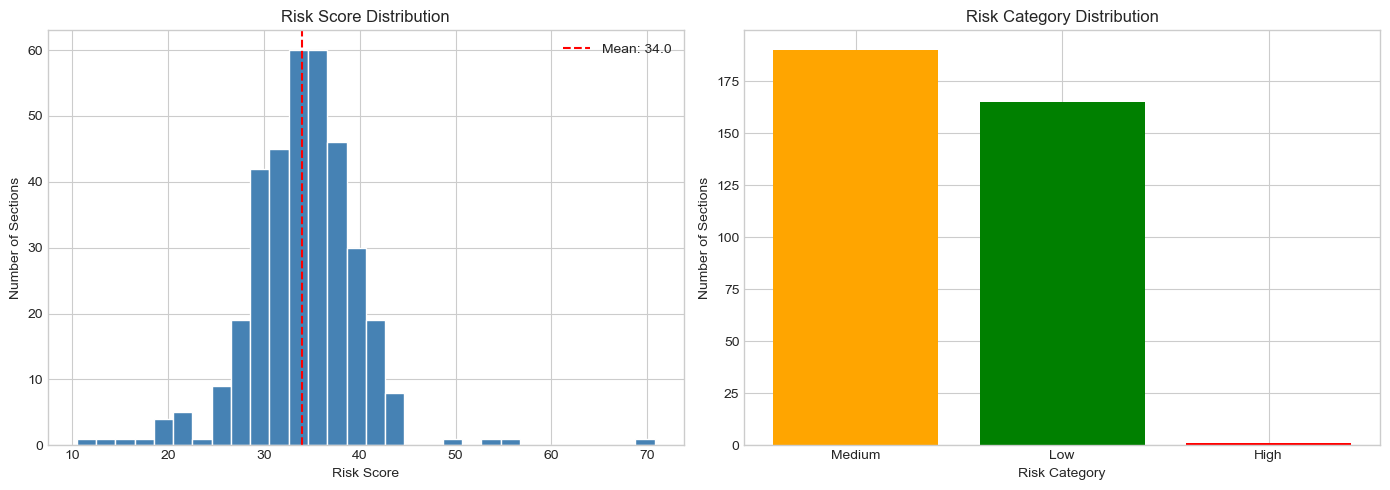

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(results['risk_score'], bins=30, color='steelblue', edgecolor='white')
axes[0].axvline(results['risk_score'].mean(), color='red', linestyle='--', label=f'Mean: {results["risk_score"].mean():.1f}')
axes[0].set_xlabel('Risk Score')
axes[0].set_ylabel('Number of Sections')
axes[0].set_title('Risk Score Distribution')
axes[0].legend()

# Category counts
category_counts = results['category'].value_counts()
colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
axes[1].bar(category_counts.index, category_counts.values, color=[colors.get(c, 'gray') for c in category_counts.index])
axes[1].set_xlabel('Risk Category')
axes[1].set_ylabel('Number of Sections')
axes[1].set_title('Risk Category Distribution')

plt.tight_layout()
plt.show()

## 4. Component Analysis

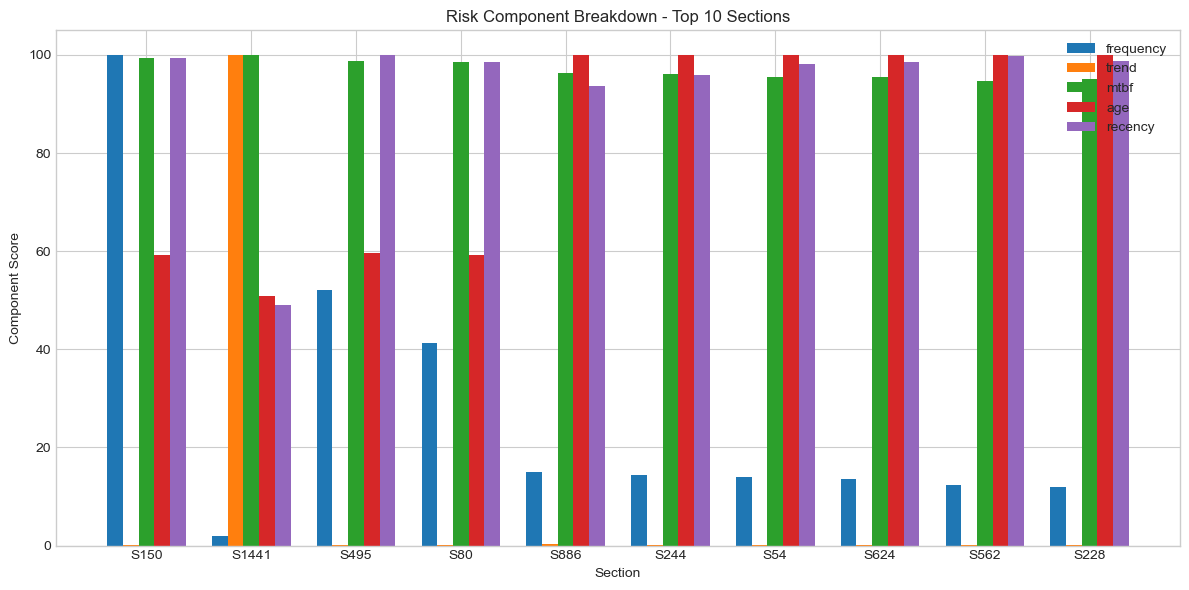

In [5]:
# Get component scores for top 10 sections
top_10 = results.head(10)

component_cols = [c for c in results.columns if c.endswith('_score') and c != 'risk_score']
if component_cols:
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(top_10))
    width = 0.15
    
    for i, col in enumerate(component_cols):
        ax.bar(x + i*width, top_10[col], width, label=col.replace('_score', ''))
    
    ax.set_xlabel('Section')
    ax.set_ylabel('Component Score')
    ax.set_title('Risk Component Breakdown - Top 10 Sections')
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels([f"S{int(s)}" for s in top_10['SectionID']])
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Component scores not available in results")

## 5. Weight Sensitivity Analysis

In [6]:
# Test different weight configurations
weight_configs = {
    'Default': {'frequency': 0.35, 'trend': 0.25, 'mtbf': 0.20, 'age': 0.10, 'recency': 0.10},
    'Frequency-Heavy': {'frequency': 0.60, 'trend': 0.15, 'mtbf': 0.10, 'age': 0.10, 'recency': 0.05},
    'Trend-Heavy': {'frequency': 0.20, 'trend': 0.50, 'mtbf': 0.15, 'age': 0.10, 'recency': 0.05},
    'Balanced': {'frequency': 0.20, 'trend': 0.20, 'mtbf': 0.20, 'age': 0.20, 'recency': 0.20}
}

rankings = {}
for name, weights in weight_configs.items():
    scorer = PMURiskScorer(pmu_df, dist_df, weights=weights)
    r = scorer.calculate_risk_scores()
    rankings[name] = r.head(10)['SectionID'].tolist()

print("Top 10 Rankings by Weight Configuration:")
for name, top_10 in rankings.items():
    print(f"\n{name}: {top_10}")

Top 10 Rankings by Weight Configuration:

Default: [150, 1441, 495, 80, 886, 244, 54, 624, 562, 228]

Frequency-Heavy: [150, 495, 80, 1441, 886, 90, 244, 54, 624, 918]

Trend-Heavy: [1441, 150, 495, 80, 886, 244, 54, 624, 562, 228]

Balanced: [150, 495, 624, 54, 562, 244, 228, 873, 886, 443]


## 6. Correlation Between Components

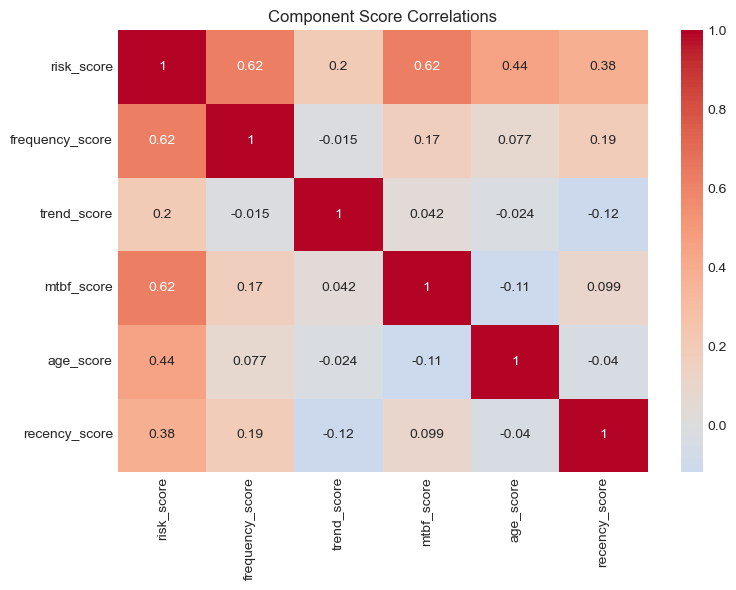

In [7]:
# Correlation heatmap
score_cols = ['risk_score'] + [c for c in results.columns if c.endswith('_score') and c != 'risk_score']
if len(score_cols) > 1:
    corr = results[score_cols].corr()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=ax)
    ax.set_title('Component Score Correlations')
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient component scores for correlation analysis")

## Summary

The multi-dimensional risk scoring framework:
- Combines 5 risk factors with configurable weights
- Section 150 consistently ranks #1 across different weight configurations
- The default weights prioritize frequency (35%) and trend (25%)
- Risk categories (Low/Medium/High) provide actionable classification